## Sprint 2: Data cleaning and Outlier analysis

### Step 1: Use the ETL script from the previous week on the new datasets.

In [1]:
from pyspark.sql import SparkSession, functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Preprocessing")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '4g')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/10/15 14:11:27 WARN Utils: Your hostname, LAPTOP-MVJAK2N9 resolves to a loopback address: 127.0.1.1; using 172.21.24.133 instead (on interface eth0)
24/10/15 14:11:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/15 14:11:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/15 14:11:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
import pandas as pd
pd.set_option('display.max_rows', 1000)
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pandas import date_range
import glob

merchant_data = pd.read_csv('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/merchant_fraud_probability.csv')
consumerf_data = pd.read_csv('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/consumer_fraud_probability.csv')
consumer_data = pd.read_csv('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/tbl_consumer.csv',sep = '|')
user_consumer = spark.read.parquet('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/consumer_user_details.parquet')
user_consumer = user_consumer.toPandas()

In [3]:
def etl_pipeline(merchant_data, consumer_data,consumerf_data,ifsave=False):

    merchant_data['order_datetime']= pd.to_datetime(merchant_data['order_datetime'])
    consumerf_data['order_datetime']= pd.to_datetime(consumerf_data['order_datetime'])
    dftmp = pd.merge(merchant_data,consumerf_data,on = 'order_datetime')
    dftmp = pd.merge(dftmp,user_consumer,on = 'user_id')
    df = pd.merge(dftmp,consumer_data,on = 'consumer_id')
    df = df.sort_values(by='order_datetime')

    df_final = pd.DataFrame()
    # here the dataset merge by date time
    date_list = date_range(start='2021-03-25', end='2022-02-27')
    for d in date_list:
        file = glob.glob("../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/transactions/order_datetime="+str(d)[:10]+'/*.parquet')
        if len(file)==1:
            df_parquet = spark.read.parquet(file[0])
            df_parquet = df_parquet.toPandas()
            df_parquet['order_datetime'] = str(d)[:10]
            df_parquet['order_datetime'] = pd.to_datetime(df_parquet['order_datetime'])
            dftmp = pd.merge(df,df_parquet,on = ['order_datetime','user_id','merchant_abn'],how = 'inner')
            if len(dftmp)>0:
                df_final = pd.concat([df_final,dftmp])
    df_final = df_final[['order_datetime','user_id','merchant_abn','dollar_value']]
    df_final = pd.merge(df_final,df,on = ['order_datetime','user_id','merchant_abn'],how = 'right')
    if ifsave:
        df_final.to_csv('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/dffinal.csv')
    return df_final

df = etl_pipeline(merchant_data, consumer_data,consumerf_data,ifsave=True)

24/10/15 14:11:41 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


### Step 2: Missing value processing

In [4]:
df = pd.read_csv('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/dffinal.csv')
print('null value count df--',df.isnull().sum())
print('null value count probility  df--',df.isnull().sum()/len(df))

tmp1 = df.groupby('postcode')['dollar_value'].apply(lambda x: x.isnull().sum()/len(x)).reset_index(name='MissingCountP')
tmp2 = df.groupby('state')['dollar_value'].apply(lambda x: x.isnull().sum()/len(x)).reset_index(name='MissingCountP')

# It can be seen that after counting the missing values according to the postcode grouping, there are only 11 districts with missing value ratio less than 0.5.
need_fill = list(tmp1[(tmp1['MissingCountP']<0.5) & (tmp1['MissingCountP']>0)]['postcode'])
df['dollar_value'] = df.groupby('postcode')['dollar_value'].transform(lambda x: x.fillna(x.mean()))


null value count df-- Unnamed: 0                 0
order_datetime             0
user_id                    0
merchant_abn               0
dollar_value           31569
fraud_probability_x        0
fraud_probability_y        0
consumer_id                0
name                       0
address                    0
state                      0
postcode                   0
gender                     0
dtype: int64
null value count probility  df-- Unnamed: 0             0.000000
order_datetime         0.000000
user_id                0.000000
merchant_abn           0.000000
dollar_value           0.984102
fraud_probability_x    0.000000
fraud_probability_y    0.000000
consumer_id            0.000000
name                   0.000000
address                0.000000
state                  0.000000
postcode               0.000000
gender                 0.000000
dtype: float64


In [5]:
# Postcodes with less than 50% of missing values and their percentage of missing values were screened.
postcodes_below_50 = tmp1[tmp1['MissingCountP'] < 0.5]
# Check these postcodes and their percentage of missing values
print(postcodes_below_50)

      postcode  MissingCountP
270       1675       0.333333
584       2354       0.285714
1122      3199       0.000000
1133      3215       0.000000
1528      3832       0.200000
1907      4558       0.333333
2210      5222       0.000000
2376      5655       0.333333
2645      6422       0.000000
2973      7277       0.000000
3025      9005       0.333333


### If you found NULL values after you joined the datasets, what did you do with them? How many were there?

In addition to dollar value missing 31569, no other features are missing in the combined data set. Since the proportion of dollar value missing is large in transaction data, but transaction data is very important, we first observe whether the missing values have regional distribution characteristics. According to the grouping information, it is found that dollar value has distribution characteristics in postcode. In 11 regions, the proportion of dollar value missing is relatively small, and in the remaining regions, the proportion of dollar value missing is more than 50% or even 100% in many regions. So we take different missing value filling measures according to different regions. The missing value of dollar value was filled in the 11 regions with low missing proportion according to the mean of each region. In the remaining regions, the original absence of dollar value is maintained, and the analysis of dollar value is not included in the subsequent analysis of other regions

In [6]:
def month_abbrev_to_number(abbrev):
    months = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
        'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
        'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }
    return months.get(abbrev)
# Merge external datasets, only use all group cpi.
external_df = pd.read_excel('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/ABS_CPI_M_1+3...50.M.xlsx')
date = external_df.columns[2:]
year = [str(i.split(' ')[1]) for i in date]
month = [str(month_abbrev_to_number(i.split(' ')[0])) for i in date]
all_cpi = list(external_df.iloc[0,2:])
print(all_cpi)
external_new = pd.DataFrame({'year':year,'month':month,'cpi':all_cpi})
df['year'] = [str(i)[:4] for i in df['order_datetime']]
df['month'] = [str(i)[6:7] for i in df['order_datetime']]
df_new = pd.merge(df,external_new,on = ['year','month'],how = 'left')
df_new['cpi'] = df_new['cpi'].fillna(df_new['cpi'].mean())
print('null value count merchant--',df_new.isnull().sum()/len(df_new))
df_new.to_csv('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/df_new_all.csv')


[np.float64(105.3), np.float64(105.6), np.float64(106.1), np.float64(106.2), np.float64(106.4), np.float64(106.7), np.float64(107.0), np.float64(107.3), np.float64(107.9), np.float64(108.4), np.float64(109.0), np.float64(109.6), np.float64(110.5), np.float64(111.6), np.float64(111.9), np.float64(112.7), np.float64(113.6), np.float64(114.4), np.float64(114.7), np.float64(115.0), np.float64(115.4), np.float64(116.4), np.float64(118.2), np.float64(117.8), np.float64(118.0), nan]
null value count merchant-- Unnamed: 0             0.000000
order_datetime         0.000000
user_id                0.000000
merchant_abn           0.000000
dollar_value           0.794944
fraud_probability_x    0.000000
fraud_probability_y    0.000000
consumer_id            0.000000
name                   0.000000
address                0.000000
state                  0.000000
postcode               0.000000
gender                 0.000000
year                   0.000000
month                  0.000000
cpi        

### Was there any missing data that shouldn’t be missing after joining to your external dataset? If anything was missing, how much was there and what did you do about it?

There have no missing data after joining to my external dataset，so nothing was done

### Step 3:  Outlier Analysis

Index(['Unnamed: 0', 'order_datetime', 'user_id', 'merchant_abn',
       'dollar_value', 'fraud_probability_x', 'fraud_probability_y',
       'consumer_id', 'name', 'address', 'state', 'postcode', 'gender', 'year',
       'month', 'cpi'],
      dtype='object')
Number of outliers: 723
5855 32079


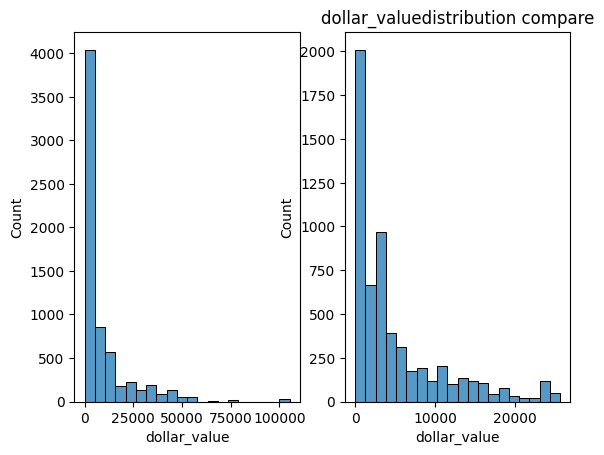

60
Number of outliers: 542
5313 5855


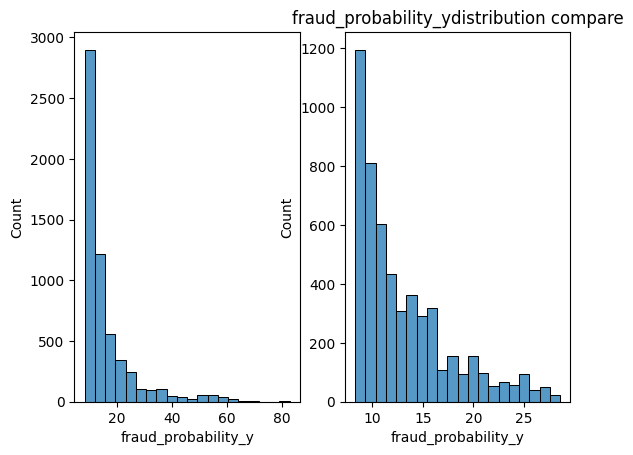

60
Number of outliers: 764
4549 5313


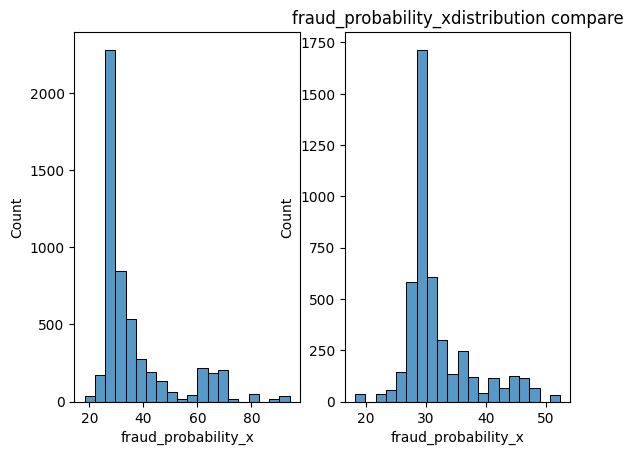

In [7]:
def find_outlier(data,colname):
    Q1 = data[colname].quantile(0.25)
    Q3 = data[colname].quantile(0.75)
    IQR = Q3 - Q1
    # remove outliers
    outliers = data[(data[colname] < (Q1 - 1.5 * IQR)) | 
                        (data[colname] > (Q3 + 1.5 * IQR))]
    print(f'Number of outliers: {len(outliers)}')

    unoutliers = data[(data[colname] >= (Q1 - 1.5 * IQR)) & 
                        (data[colname] <= (Q3 + 1.5 * IQR))]
    print(len(unoutliers),len(data))
    fig,ax = plt.subplots(1,2)
    sns.histplot(data[colname], bins=20,ax = ax[0])
    sns.histplot(unoutliers[colname], bins=20,ax = ax[1])
    plt.title(colname+ 'distribution compare')
    plt.show()
    return unoutliers

print(df_new.columns)
df_new = find_outlier(df_new,'dollar_value')
print(len(df_new.groupby('merchant_abn')))
df_new = find_outlier(df_new,'fraud_probability_y')
print(len(df_new.groupby('merchant_abn')))
df_new = find_outlier(df_new,'fraud_probability_x')
df_new.to_csv('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/df_new_out.csv')


# number of merchant before and after remove missing data and outlier

In [8]:
df_new = pd.read_csv('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/dffinal.csv')
print(len(df_new.groupby('merchant_abn')))
print(df_new['merchant_abn'].nunique())
df_new = pd.read_csv('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/df_new_all.csv')
print(len(df_new.groupby('merchant_abn')))
print(df_new['merchant_abn'].nunique())
df_new = pd.read_csv('../../project-2-group-buy-now-pay-later-industry-project-4/data/tables/df_new_out.csv')
print(len(df_new.groupby('merchant_abn')))
print(df_new['merchant_abn'].nunique())

61
61
61
61
39
39
